<a href="https://colab.research.google.com/github/bndxn/dissertation/blob/main/Model_4_RNN_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model 3 trained using a ConvLSTM but gave the strange result that the validation error was lower than the training error. I will recreate the pipeline and check this result. 

In [1]:
pip install h5netcdf zarr xarray[complete] gcsfs --quiet

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm

/usr/local/lib/python3.7/dist-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
import gcsfs
import google.auth
from google.colab import auth

auth.authenticate_user()

credentials, project_id = google.auth.default()
fs = gcsfs.GCSFileSystem(project="my-project", token=credentials)

# Loading satellite data from source

In [8]:
SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr" 

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr", 
    chunks="auto",  # Load the data as a Dask array.
)

data_array = dataset['data']

/usr/local/lib/python3.7/dist-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [16]:
data_array

<xarray.DataArray 'data' (time: 173624, y: 891, x: 1843)>
dask.array<open_dataset-cf51b8b4975749e4351315ef47e6371cdata, shape=(173624, 891, 1843), dtype=int16, chunksize=(22, 891, 1843), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Attributes:
    _satpy_id:                              !!python/object/apply:satpy.datas...
    ancillary_variables:                    []
    area:                                   msg_seviri_rss_1km:\n  descriptio...
    calibration:                            reflectance
    coordinates:                            acq_time
    georef_offset_corrected:                True
    modifiers:                              []
    name:                                   HRV
    orbital_parameters:                     projection_altitude: 35785831.0\n...
    platform_name:                          Meteosat-10
    reader:                                 seviri_l1b_native
    resolution:                             1000.134348869
    sensor:                                 seviri
    standard_name:                          toa_bidirectional_reflectance
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    wavelength:                             [0.5, 0.7, 0.9, 'µm']

In [9]:
def get_day_slice(date):
    data_slice = data_array.loc[
        {
            # 10am to 4pm
            "time": slice(
                date + datetime.timedelta(hours=6),
                date + datetime.timedelta(hours=20),
            )
        }
    ].isel(
        x=slice(850, 850+128),
        y=slice(300, 300+128),
    )
    
    # sometimes there is no data
    if len(data_slice.time) == 0:
        return None
    return data_slice

In [14]:
# Taking the first 7 days for training and 2 days later for validation

import datetime

training_dates = []

for i in range(2020,2021+1):
  for j in range(1,12+1):
    for k in range(1,7+1):
      training_dates.append(datetime.datetime(i, j, k))

validation_dates = []

for i in range(2020,2021+1):
  for j in range(1,12+1):
    for k in range(10,11+1):
      validation_dates.append(datetime.datetime(i, j, k))


training_slices = []
for date in tqdm.tqdm(training_dates):
    slc = get_day_slice(date)
    if slc is None:
        continue
    training_slices.append(slc)

training_sat_images = xr.concat(training_slices, dim='time')

validation_slices = []
for date in tqdm.tqdm(validation_dates):
    slc = get_day_slice(date)
    if slc is None:
        continue
    validation_slices.append(slc)

validation_sat_images = xr.concat(validation_slices, dim='time')

100%|██████████| 48/48 [00:00<00:00, 538.20it/s]


In [19]:
training_sat_images

<xarray.DataArray 'data' (time: 24146, y: 128, x: 128)>
dask.array<concatenate, shape=(24146, 128, 128), dtype=int16, chunksize=(22, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T06:00:00 ... 2021-11-07T15:50:00
  * x        (x) float32 -8.221e+05 -8.231e+05 ... -9.481e+05 -9.491e+05
    x_osgb   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * y        (y) float32 4.498e+06 4.499e+06 4.5e+06 ... 4.624e+06 4.625e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
Attributes:
    _satpy_id:                              !!python/object/apply:satpy.datas...
    ancillary_variables:                    []
    area:                                   msg_seviri_rss_1km:\n  descriptio...
    calibration:                            reflectance
    coordinates:                            acq_time
    georef_offset_corrected:                True
    modifiers:                              []
    name:                                   HRV
    orbital_parameters:                     projection_altitude: 35785831.0\n...
    platform_name:                          Meteosat-10
    reader:                                 seviri_l1b_native
    resolution:                             1000.134348869
    sensor:                                 seviri
    standard_name:                          toa_bidirectional_reflectance
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   1.0282367454433767
    wavelength:                             [0.5, 0.7, 0.9, 'µm']

In [20]:
# This took 24 minutes to run

# np.save('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_images_train.npy', training_sat_images)
# np.save('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_train.npy', training_sat_images.time)

# np.save('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_images_test.npy', validation_sat_images)
# np.save('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_test.npy', validation_sat_images.time)


In [77]:
training_sat_images = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_images_train.npy')
training_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_train.npy')

validation_sat_images = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_images_test.npy')
validation_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_test.npy')

# Load PV data


In [78]:
pv_power = xr.open_dataset("/content/drive/My Drive/Colab Notebooks/dissertation/uk_pv/pv.netcdf", engine="h5netcdf")
devon_ss_ids = [5444, 6835, 7159, 7245, 7276, 7763] # we previously found these sites in Devon with PV readings

dataframes = []
for ss_id in devon_ss_ids:
    dataframes.append(pv_power['{}'.format(ss_id)].to_dataframe())

pv_df = pd.concat(dataframes, axis=1)
pv_df['Mean'] = pv_df.mean(axis=1)

#cropping to match 6am to 8pm span, same as satellite (but not quite, excludes 6:00 and 20:00)
pv_df = pv_df[(pv_df.index.hour > 5) & (pv_df.index.hour < 20)]

# Match up PV data with satellite data

In [79]:
print(pv_df.shape)
print(training_sat_images.shape)
print(training_sat_times.shape)
print(validation_sat_images.shape)
print(validation_sat_times.shape)

(233458, 7)
(24146, 128, 128)
(24146,)
(6555, 128, 128)
(6555,)


In [80]:
# Create arrays of the pv readings for the timestamps for the images

train_pv_readings = []

for time in training_sat_times:
  try:
    reading = pv_df.Mean[pv_df.index == time][0]
    train_pv_readings.append(reading)

  except IndexError:
    train_pv_readings.append(0)
  
train_pv = np.asarray(train_pv_readings, dtype=object).astype('float32')

len(train_pv)

24146

In [81]:
test_pv_readings = []

counter = 0
for time in validation_sat_times:
  try:
    reading = pv_df.Mean[pv_df.index ==time][0]
    test_pv_readings.append(reading)
  except IndexError:
    test_pv_readings.append(0)
    counter += 1

test_pv = np.asarray(test_pv_readings, dtype=object).astype('float32')

print(len(test_pv))
print(counter) 

6555
40


In [82]:
# We now have train_pv and test_pv giving readings for each of the satellite image points

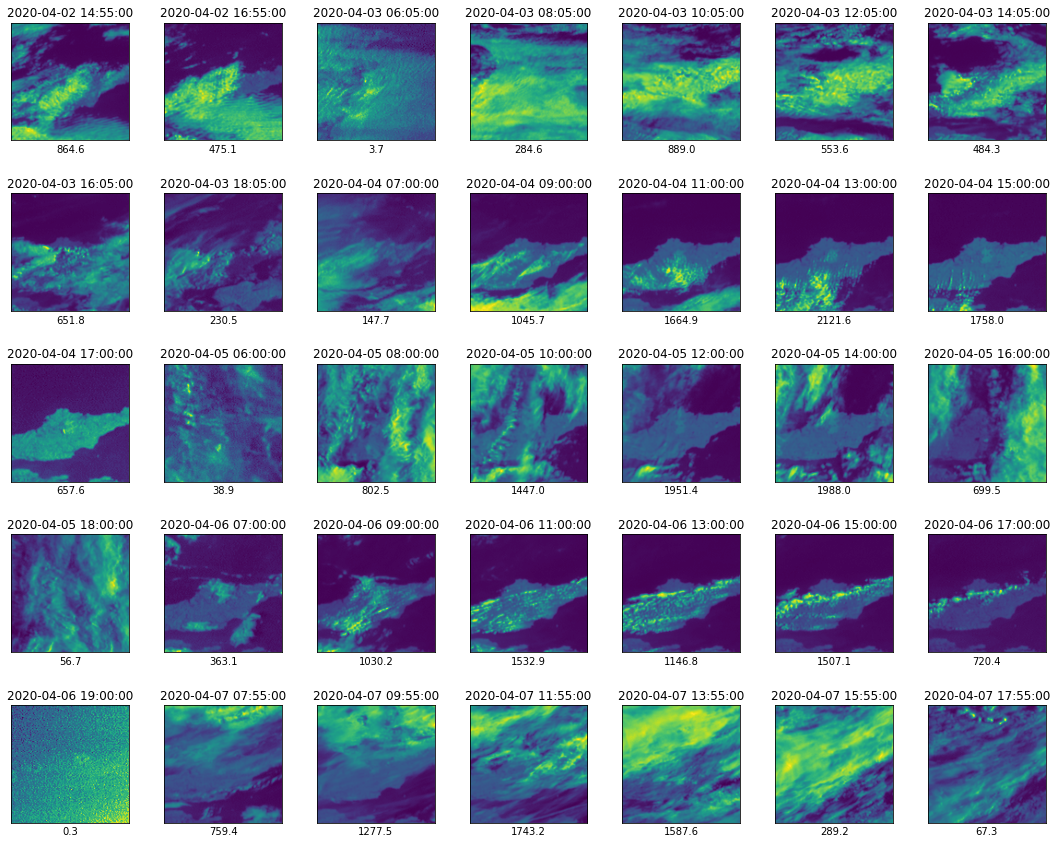

In [164]:
# Looks pretty plausible and well matched-up

def print_prepared_grid(image_array, title_timestamps, pv_array, start, spacing):

    plt.figure(figsize=(15,12))
    for i in range(0,35):
        plt.subplot(5,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_array[i*spacing+start])
        plt.title(pd.Timestamp(title_timestamps[i*spacing+start]))
        plt.xlabel(round(pv_array[i*spacing+start],1))
    plt.tight_layout()
    plt.show()

print_prepared_grid(training_sat_images, training_sat_times, train_pv, 2076, 24)

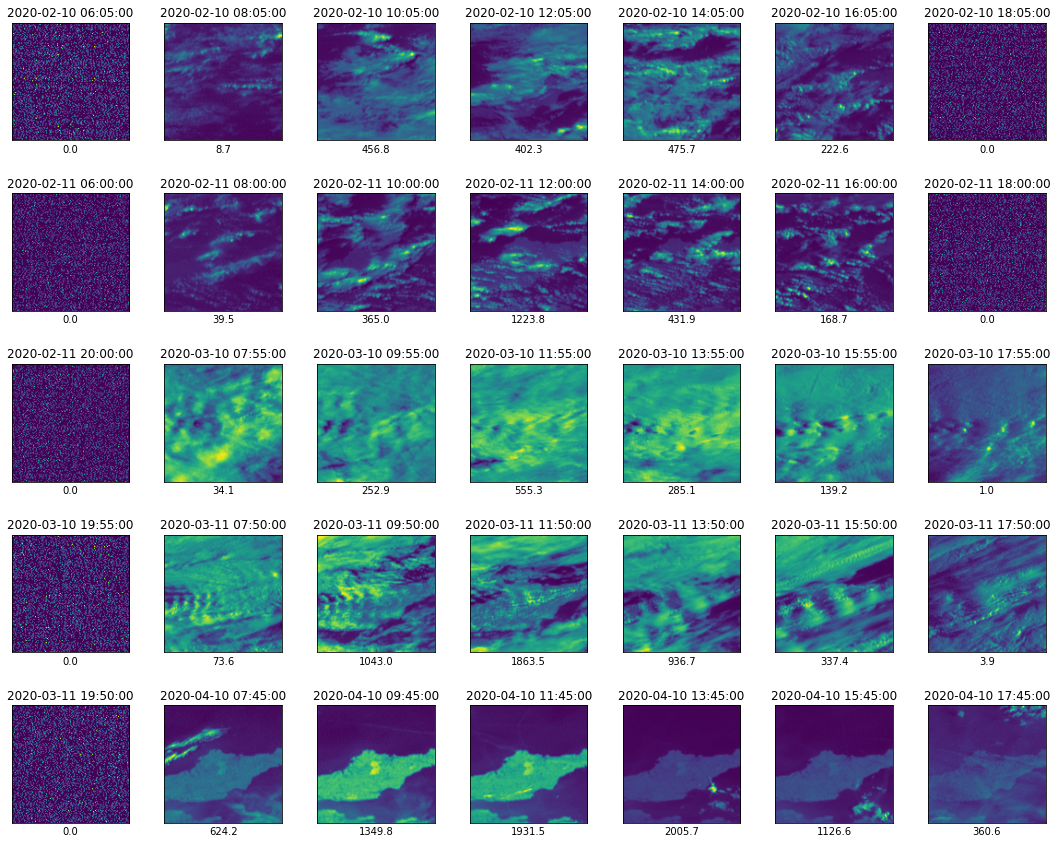

In [167]:
# Test/validation data also looks pretty plausible and well matched-up

print_prepared_grid(validation_sat_images, validation_sat_times, test_pv, 1, 24)

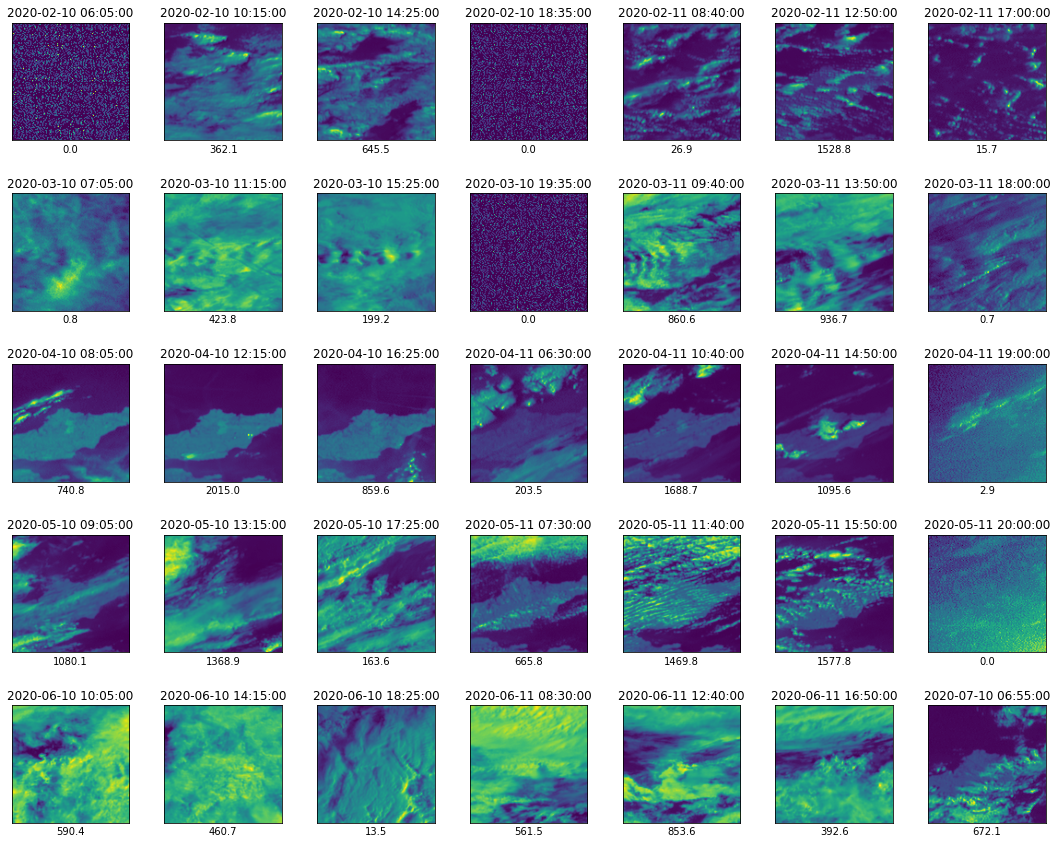

In [168]:
print_prepared_grid(validation_sat_images, validation_sat_times, test_pv, 1, 50)

In [100]:
train_pv.shape

(19571,)

In [175]:
np.nanmean(test_pv_no_zeros)

652.28467

In [176]:
np.nanmean(train_pv_no_zeros)

668.38947

In [117]:
np.arange(0, len(train_pv))

array([    0,     1,     2, ..., 19568, 19569, 19570])

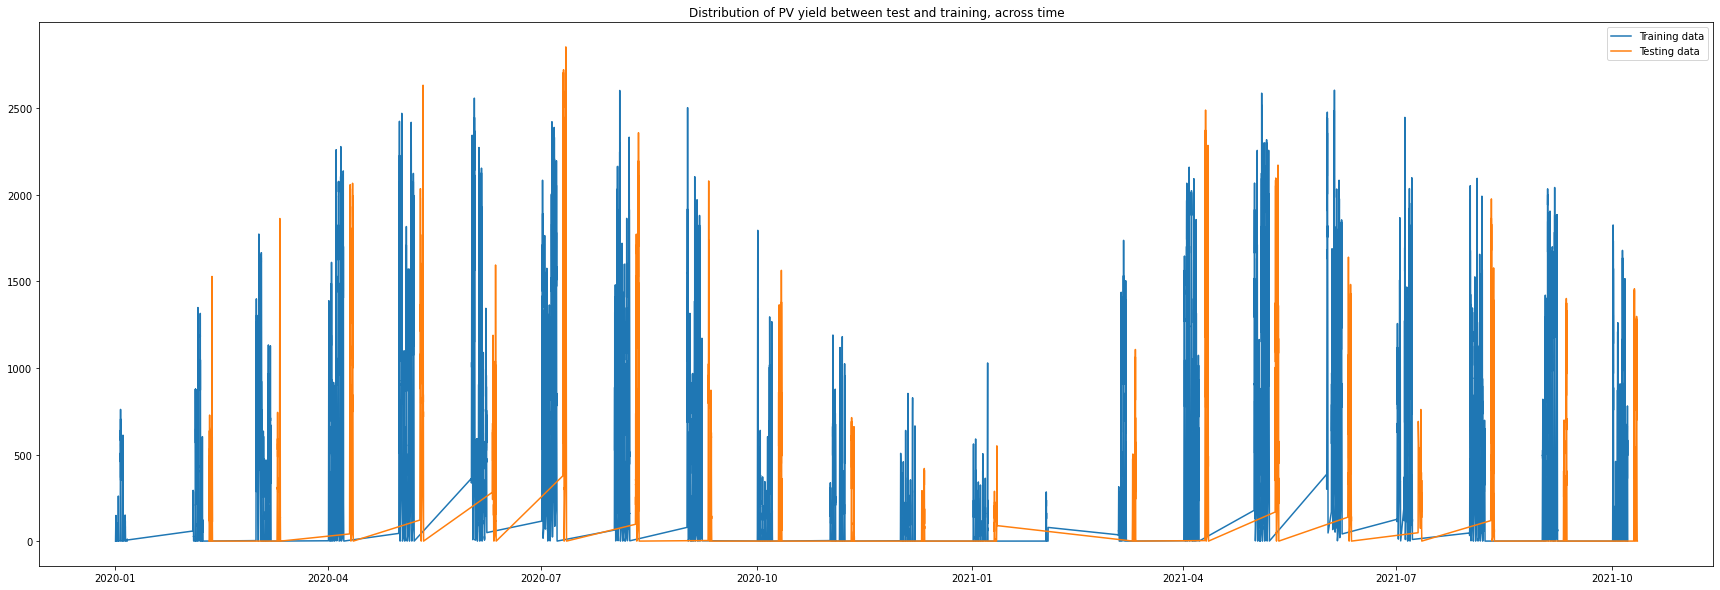

In [171]:
plt.figure(figsize=(30,10))
plt.plot(training_sat_times, train_pv, label='Training data')
plt.plot(validation_sat_times, test_pv, label='Testing data')
plt.title('Distribution of PV yield between test and training, across time')
plt.legend()

In [182]:
counter = 0
for i in train_pv:
  if i < 0.01:
    counter +=1

print(counter/len(train_pv)*100, '% of training data is less than 0.01')

0.3525624648714935 % of training data is less than 0.01


In [181]:
counter = 0 
for i in test_pv:
  if i < 0.01:
    counter +=1

print(counter/len(test_pv)*100, '% of training data is less than 0.01')

14.706331045003814 % of training data is less than 0.01


In [183]:
# Deleting all the data for which the PV value is zero 
# The position arrays here are arrays 

test_positions = []

test_zeros = 0
test_not_zeros = 0
for i in range(test_pv.shape[0]):
  if test_pv[i] < 0.0001:
    test_positions.append(i)
    test_not_zeros +=1
  else:
    test_zeros +=1

test_pv_no_zeros = np.delete(test_pv, test_positions, axis=0)
validation_sat_images_no_zeros = np.delete(validation_sat_images, test_positions, axis=0)
validation_sat_times_no_zeros = np.delete(validation_sat_times, test_positions, axis=0)

train_positions = []

train_zeros = 0
train_not_zeros =0
for i in range(train_pv.shape[0]):
  if train_pv[i] < 0.0001:
    train_positions.append(i)
    train_not_zeros +=1
  else:
    train_zeros +=1

train_pv_no_zeros = np.delete(train_pv, train_positions, axis=0)
training_sat_images_no_zeros = np.delete(training_sat_images, train_positions, axis=0)
training_sat_times_no_zeros = np.delete(training_sat_times, train_positions, axis=0)

print('Test data, zeros: ', test_zeros, ' , non-zero:', test_not_zeros, ' total :', test_pv.shape[0])
print('Training data, zeros: ', train_zeros, ' , non-zero:', train_not_zeros, ' total :', train_pv.shape[0])

Test data, zeros:  5620  , non-zero: 935  total : 6555
Training data, zeros:  19571  , non-zero: 0  total : 19571


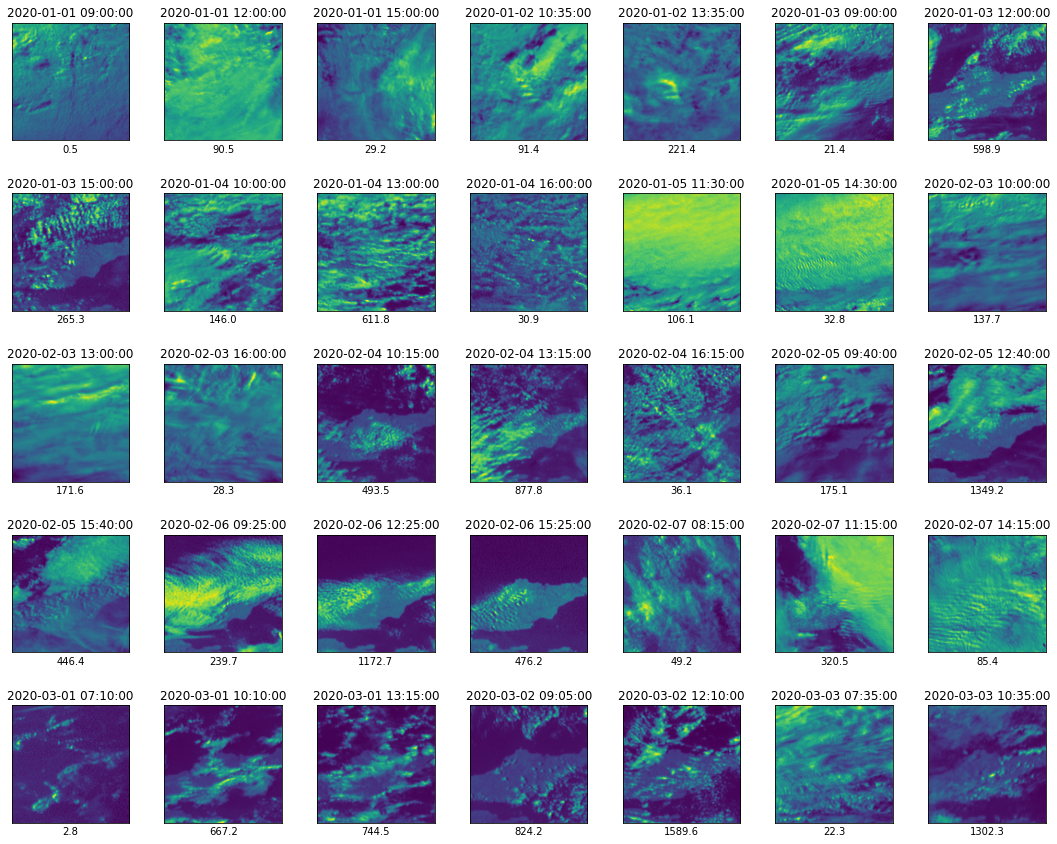

In [187]:
print_prepared_grid(training_sat_images_no_zeros, training_sat_times_no_zeros, train_pv_no_zeros, 1, 36)

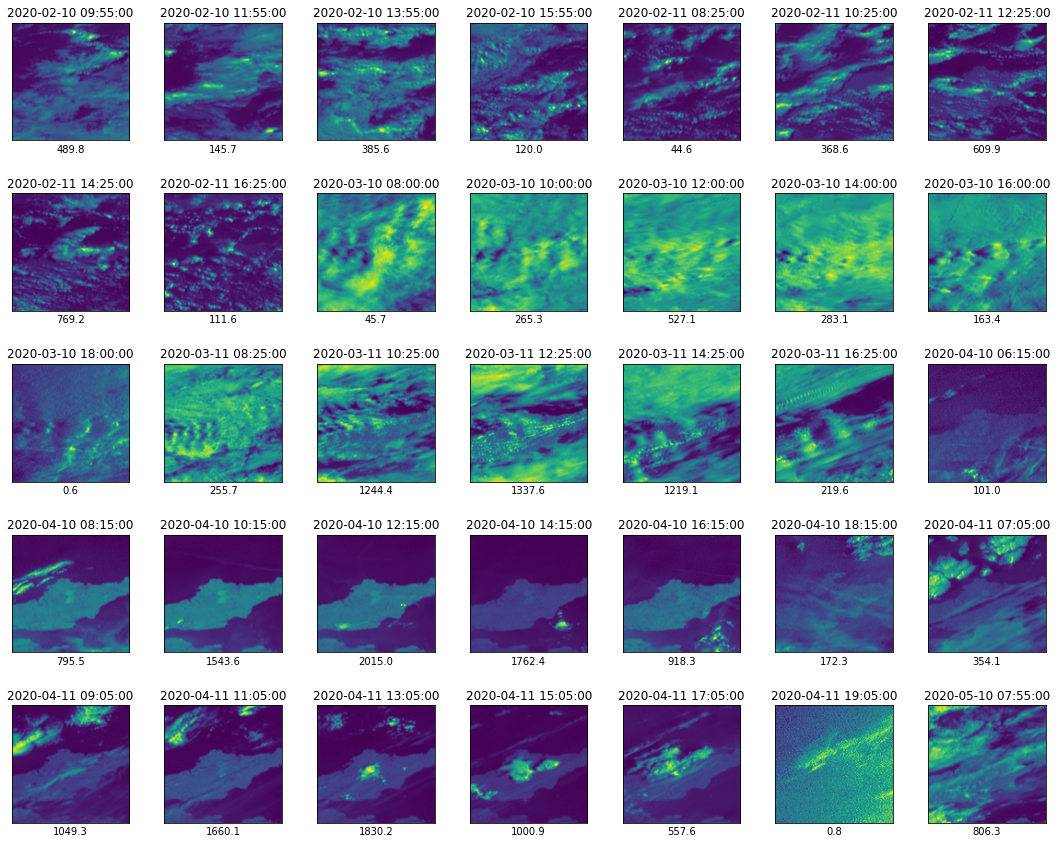

In [190]:
print_prepared_grid(validation_sat_images_no_zeros, validation_sat_times_no_zeros, test_pv_no_zeros, 25, 24)

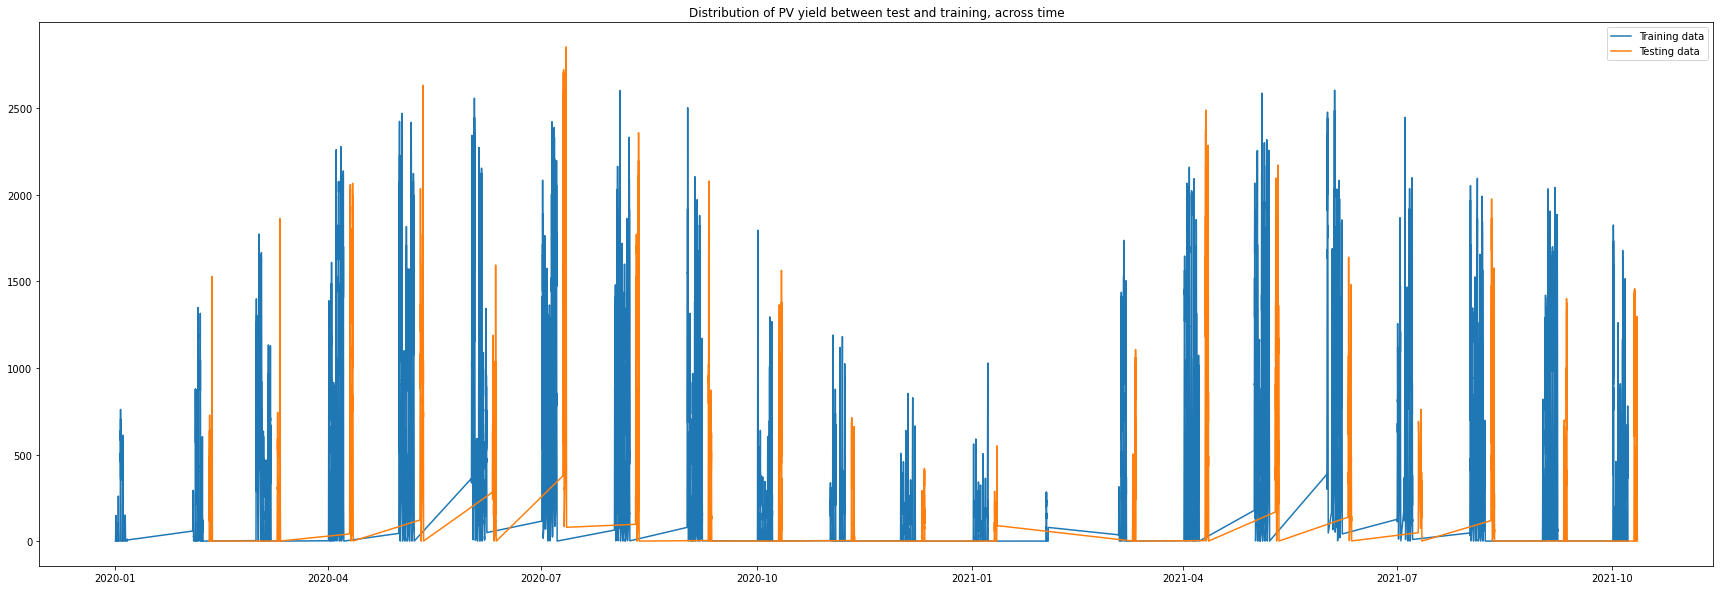

In [191]:
plt.figure(figsize=(30,10))
plt.plot(training_sat_times_no_zeros, train_pv_no_zeros, label='Training data')
plt.plot(validation_sat_times_no_zeros, test_pv_no_zeros, label='Testing data')
plt.title('Distribution of PV yield between test and training, across time')
plt.legend()

In [193]:
np.nanmean(train_pv_no_zeros)

668.38947

In [194]:
np.nanmean(test_pv_no_zeros)

650.6597

In [195]:
print(validation_sat_images_no_zeros.shape)
print(validation_sat_times_no_zeros.shape)
print(test_pv_no_zeros.shape)

print(training_sat_images_no_zeros.shape)
print(training_sat_times_no_zeros.shape)
print(train_pv_no_zeros.shape)


(5620, 128, 128)
(5620,)
(5620,)
(19571, 128, 128)
(19571,)
(19571,)


# Create blocks

In [198]:
def get_list_of_days(list_of_timestamps):

  list_of_days = []

  for i in list_of_timestamps:
    list_of_days.append(pd.Timestamp(i).date())

  list_of_days = list(dict.fromkeys(list_of_days))
  
  return list_of_days

def get_blocks_of_timestamps_for_day(date, list_of_timestamps):

  timestamps_in_day = []

  for i in list_of_timestamps:
    if pd.Timestamp(i).date() == date:
      timestamps_in_day.append(i)

  blocks_in_day = len(timestamps_in_day) // 5 

  block_list = []

  for i in range(blocks_in_day-1): 
    block_list.append(timestamps_in_day[i*5:(i+1)*5]) 

  block_list = np.asarray(block_list) 

  return block_list


def get_pv_and_sat_blocks(block_list, sat_data, pv_data, list_of_timestamps):

  #pv_readings = np.zeros(shape=(len(block_list),5)) 
  sat_readings = np.zeros(shape=(len(block_list), 5, 128, 128))
  pv_targets = np.zeros(shape=(len(block_list))) 

  # loop through the columns and rows of block_list to get the timestamps

  for i in range(block_list.shape[0]):
    for j in range(block_list.shape[1]):
      timestamp = block_list[i,j]

  # within this loop, get the index in the train_sat_times array for this timestamp

      index = np.where(list_of_timestamps == timestamp)[0][0]

      #pv_readings[i,j] = train_pv[index] - can include this when doing multiple inputs      
      sat_readings[i,j] = sat_data[index]

    pv_targets[i] = pv_data[index+1] 

  return sat_readings, pv_targets


def ben_generator(list_of_timestamps, sat_data, pv_data):
 
    list_of_days = get_list_of_days(list_of_timestamps)

    sat_readings_list = []
    pv_targets_list = []

    for day in list_of_days:

      block_list = get_blocks_of_timestamps_for_day(day, list_of_timestamps)

      sat_readings, pv_targets = get_pv_and_sat_blocks(block_list, sat_data, pv_data, list_of_timestamps)

      sat_readings_list.append(sat_readings)
      pv_targets_list.append(pv_targets)

    sat_readings = np.concatenate(sat_readings_list)
    pv_targets = np.concatenate(pv_targets_list)

    # print(sat_readings.shape)
    # print(pv_targets.shape)

    return sat_readings, pv_targets


In [213]:
train_data, train_labels = ben_generator(training_sat_times, training_sat_images, train_pv)
test_data, test_labels = ben_generator(validation_sat_times, validation_sat_images, test_pv)

train_data /= 255
test_data  /= 255

max = np.nanmax(train_labels)

train_labels /= (max + 1)
test_labels /=  (max + 1)

In [214]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(3710, 5, 128, 128)
(3710,)
(1241, 5, 128, 128)
(1241,)


In [215]:
from keras import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.ConvLSTM2D(32, kernel_size=(3,3), input_shape=(5, 128, 128, 1))) 
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(x=train_data, y=train_labels, steps_per_epoch=200, epochs=5, validation_data=(test_data, test_labels))



Epoch 1/5
200/200 [==============================] - 70s 337ms/step - loss: 0.1808 - val_loss: 0.1761
Epoch 2/5
200/200 [==============================] - 67s 338ms/step - loss: 0.1775 - val_loss: 0.1775
Epoch 3/5
200/200 [==============================] - 68s 342ms/step - loss: 0.1757 - val_loss: 0.1812
Epoch 4/5
200/200 [==============================] - 69s 346ms/step - loss: 0.1755 - val_loss: 0.1755
Epoch 5/5
200/200 [==============================] - 63s 316ms/step - loss: 0.1747 - val_loss: 0.1774


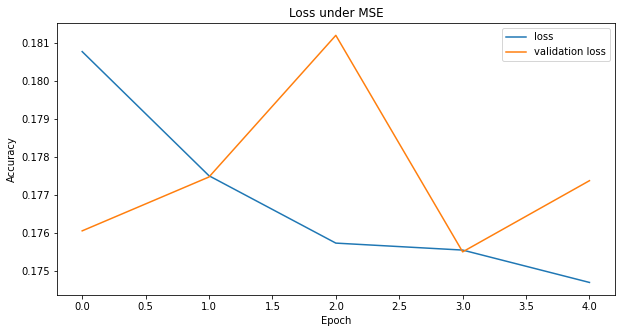

In [216]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Loss under MSE')
plt.legend();
